In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pickle
%matplotlib inline

In [2]:
student_mat = pd.read_csv("student-mat.csv", sep = ";")
student_por = pd.read_csv("student-por.csv", sep = ";")
print(student_mat.head())
print(student_por.head())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other ...   
3     GP   F   15       U     GT3       T     4     2   health  services ...   
4     GP   F   16       U     GT3       T     3     3    other     other ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob ...  \
0     GP   F  

Согласно следующему тесту, потребление алкоголя для различных курсов с большой вероятностью имеет общее распределение.
Следовательно, можно объединить данные из двух курсов, без существенного ухудшения точности предсказания для каждого в отдельности.

In [3]:
print(stats.ks_2samp(student_mat['Walc'], student_por['Walc']))
print(stats.ks_2samp(student_mat['Dalc'], student_por['Dalc']))
students = pd.concat([student_mat, student_por])
print(students.shape)

Ks_2sampResult(statistic=0.014241969144350608, pvalue=0.99999999971045828)
Ks_2sampResult(statistic=0.0072516627333190087, pvalue=1.0000000000000002)
(1044, 33)


Поскольку мы хотим предсказывать потребление алкоголя в общем, объединим данные по потреблению алкоголя в будни и выходные.

In [4]:
students['alc'] = students['Walc'] + students['Dalc']
students = students.drop(['Walc','Dalc'],1)
print(students.head())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other ...   
3     GP   F   15       U     GT3       T     4     2   health  services ...   
4     GP   F   16       U     GT3       T     3     3    other     other ...   

  romantic famrel  freetime  goout  health absences  G1  G2  G3 alc  
0       no      4         3      4       3        6   5   6   6   2  
1       no      5         3      3       3        4   5   5   6   2  
2       no      4         3      2       3       10   7   8  10   5  
3      yes      3         2      2       5        2  15  14  15   2  
4       no      4         3      2       5        4   6  10  10   3  

[5 rows x 32 columns]


Построим гистограмму распределения количества употребляемого алкоголя.

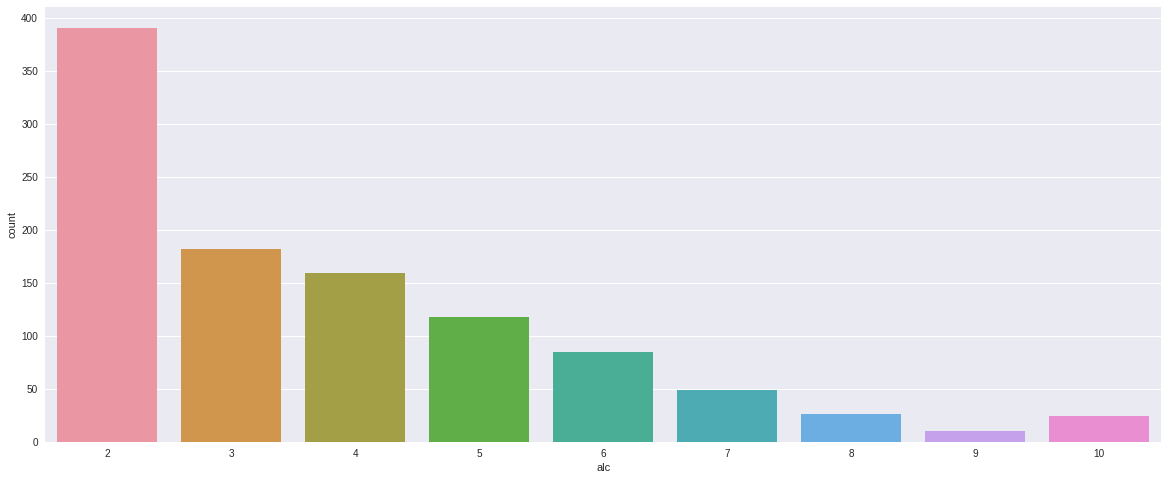

In [15]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (20, 8)
sns.countplot(x='alc', data=students)

Используя ансамбль решающих деревьев, попробуем найти 10 наиболее значимых признаков для предсказания употребления алкоголя студентами. 

Feature ranking:
1. feature 8 (0.047959)
2. feature 0 (0.034975)
3. feature 9 (0.034143)
4. feature 7 (0.033498)
5. feature 2 (0.032675)
6. feature 6 (0.032597)
7. feature 1 (0.032290)
8. feature 4 (0.031256)
9. feature 3 (0.027350)
10. feature 10 (0.022033)


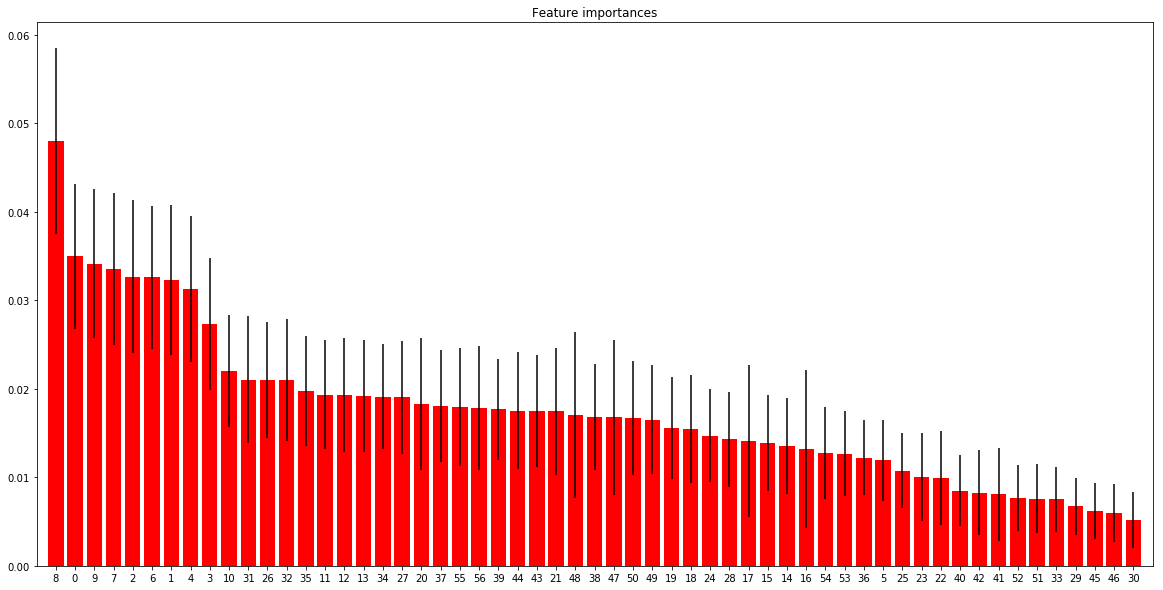

In [6]:
from sklearn.ensemble import ExtraTreesClassifier

y = students['alc']
X = students.drop(['alc'],1)
X = pd.get_dummies(X)


forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# вывод 10 наиболее значимых признаков
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# построение графика
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Оставим 10 наиболее значимых признаков и заменим категориальные значения на численные.

In [7]:
X = students[[8,0,9,7,2,6,1,4,3,10]]
X = X.replace(['teacher','health','services','at_home','other','GP','MS','M','F','LE3','GT3','U','R','home','reputation','course','other'],
            [0,1,2,3,4,0,1,1,0,0,1,0,1,0,1,2,3])
print(X.shape)
print(X.head())

(1044, 10)
   Mjob  school  Fjob  Fedu  age  Medu  sex  famsize  address  reason
0     3       0     0     4   18     4    0        1        0       2
1     3       0     4     1   17     1    0        1        0       2
2     3       0     4     1   15     1    0        0        0       4
3     1       0     2     2   15     4    0        1        0       0
4     4       0     4     3   16     3    0        1        0       0


Разделим датасет на тренировочные и тестовые множества.

In [8]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

Используя 10 наиболее значимых признаков, для начала построим простую модель в качестве baseline, для сравнения с будущей моделью.

In [9]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.387559808612


Попробуем добиться большей точности, используя модуль XGBoost со встроенной кросс-валидацией.

In [10]:
import xgboost
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [11]:
model.score(X_test, y_test)

0.46411483253588515

Результат не сильно превзошёл baseline, из чего можно сделать вывод о необходимости выбора более подходящих парметров XGBoost или используемых признаков, применяя другие техники отбора: principal component analysis (PCA), recursive feature elimination (RFE), univariate feature selection (модуль SelectKBest в Scikit-Learn) или эмпирический анализ данных.

Кроме того, необходимо протестировать датасет на других моделях машинного обучения, например, используя библиотеку AutoML

Для ответа на дополнительный вопрос воспользуемся различными техниками визуализации данных.

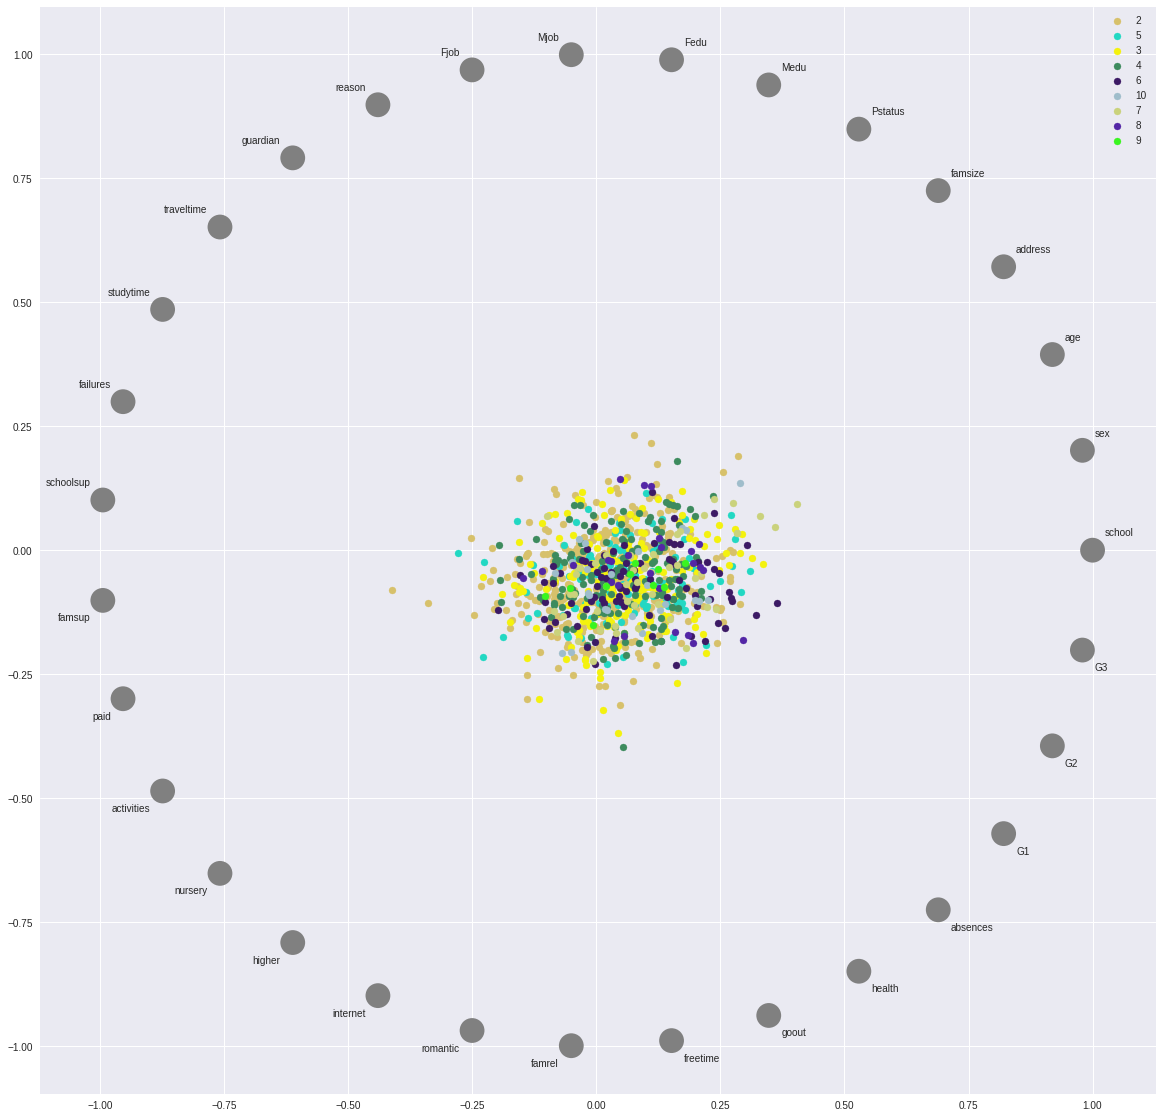

In [40]:
from pandas.tools.plotting import radviz, scatter_matrix, parallel_coordinates
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
for col in students.columns.values:
    if students[col].dtypes=='object':
        le.fit(students[col].values)
        students[col]=le.transform(students[col])

plt.figure(figsize = (20,20))
radviz(students, 'alc')

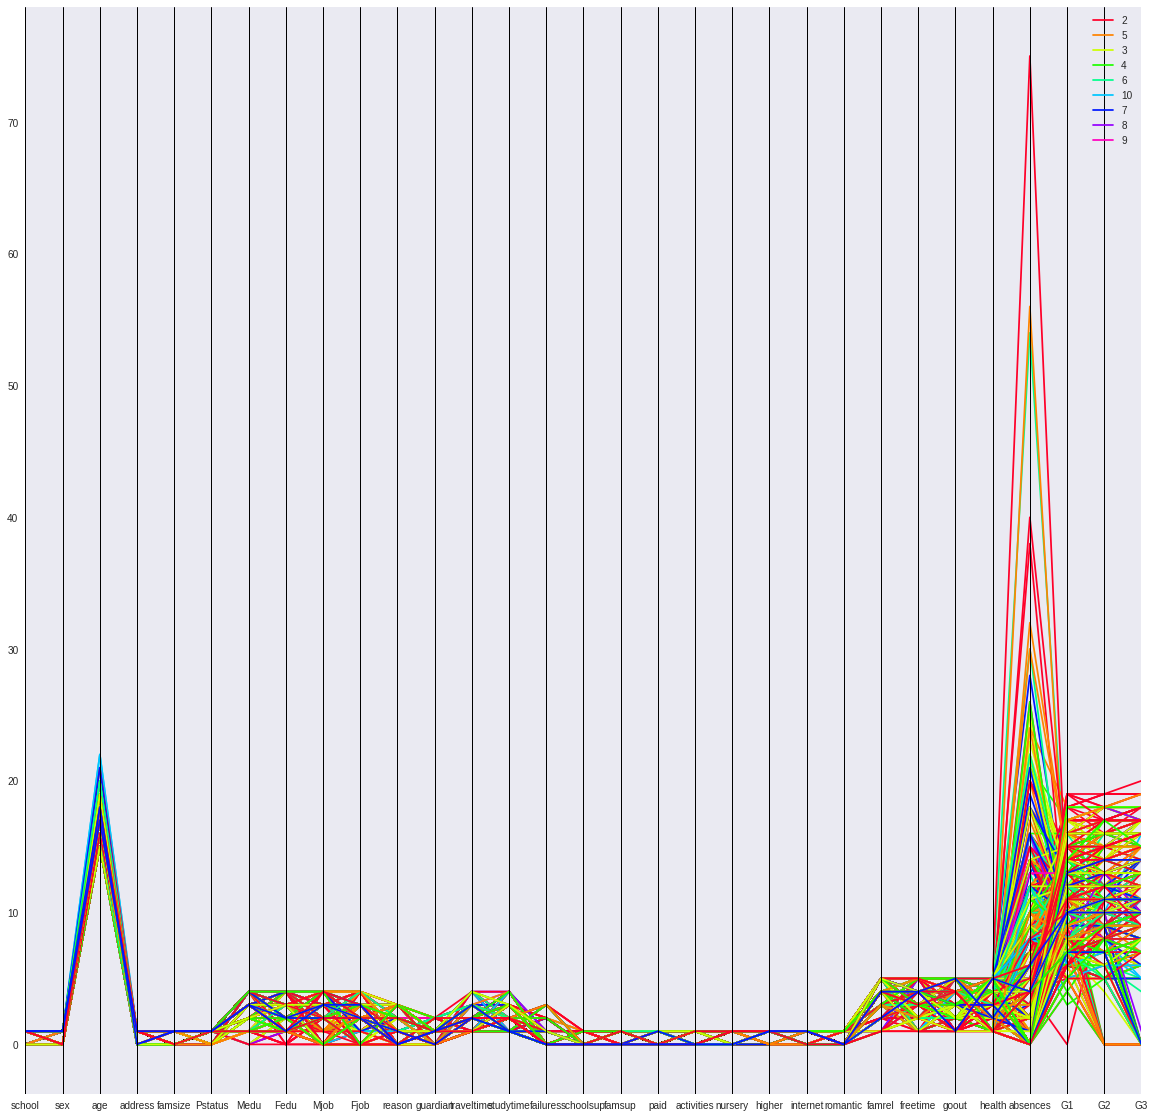

In [30]:
plt.figure(figsize = (20,20))
parallel_coordinates(students, 'alc', colormap='gist_rainbow')

2     Axes(0.1,0.829245;0.8x0.0707547)
3      Axes(0.1,0.74434;0.8x0.0707547)
4     Axes(0.1,0.659434;0.8x0.0707547)
5     Axes(0.1,0.574528;0.8x0.0707547)
6     Axes(0.1,0.489623;0.8x0.0707547)
7     Axes(0.1,0.404717;0.8x0.0707547)
8     Axes(0.1,0.319811;0.8x0.0707547)
9     Axes(0.1,0.234906;0.8x0.0707547)
10        Axes(0.1,0.15;0.8x0.0707547)
dtype: object

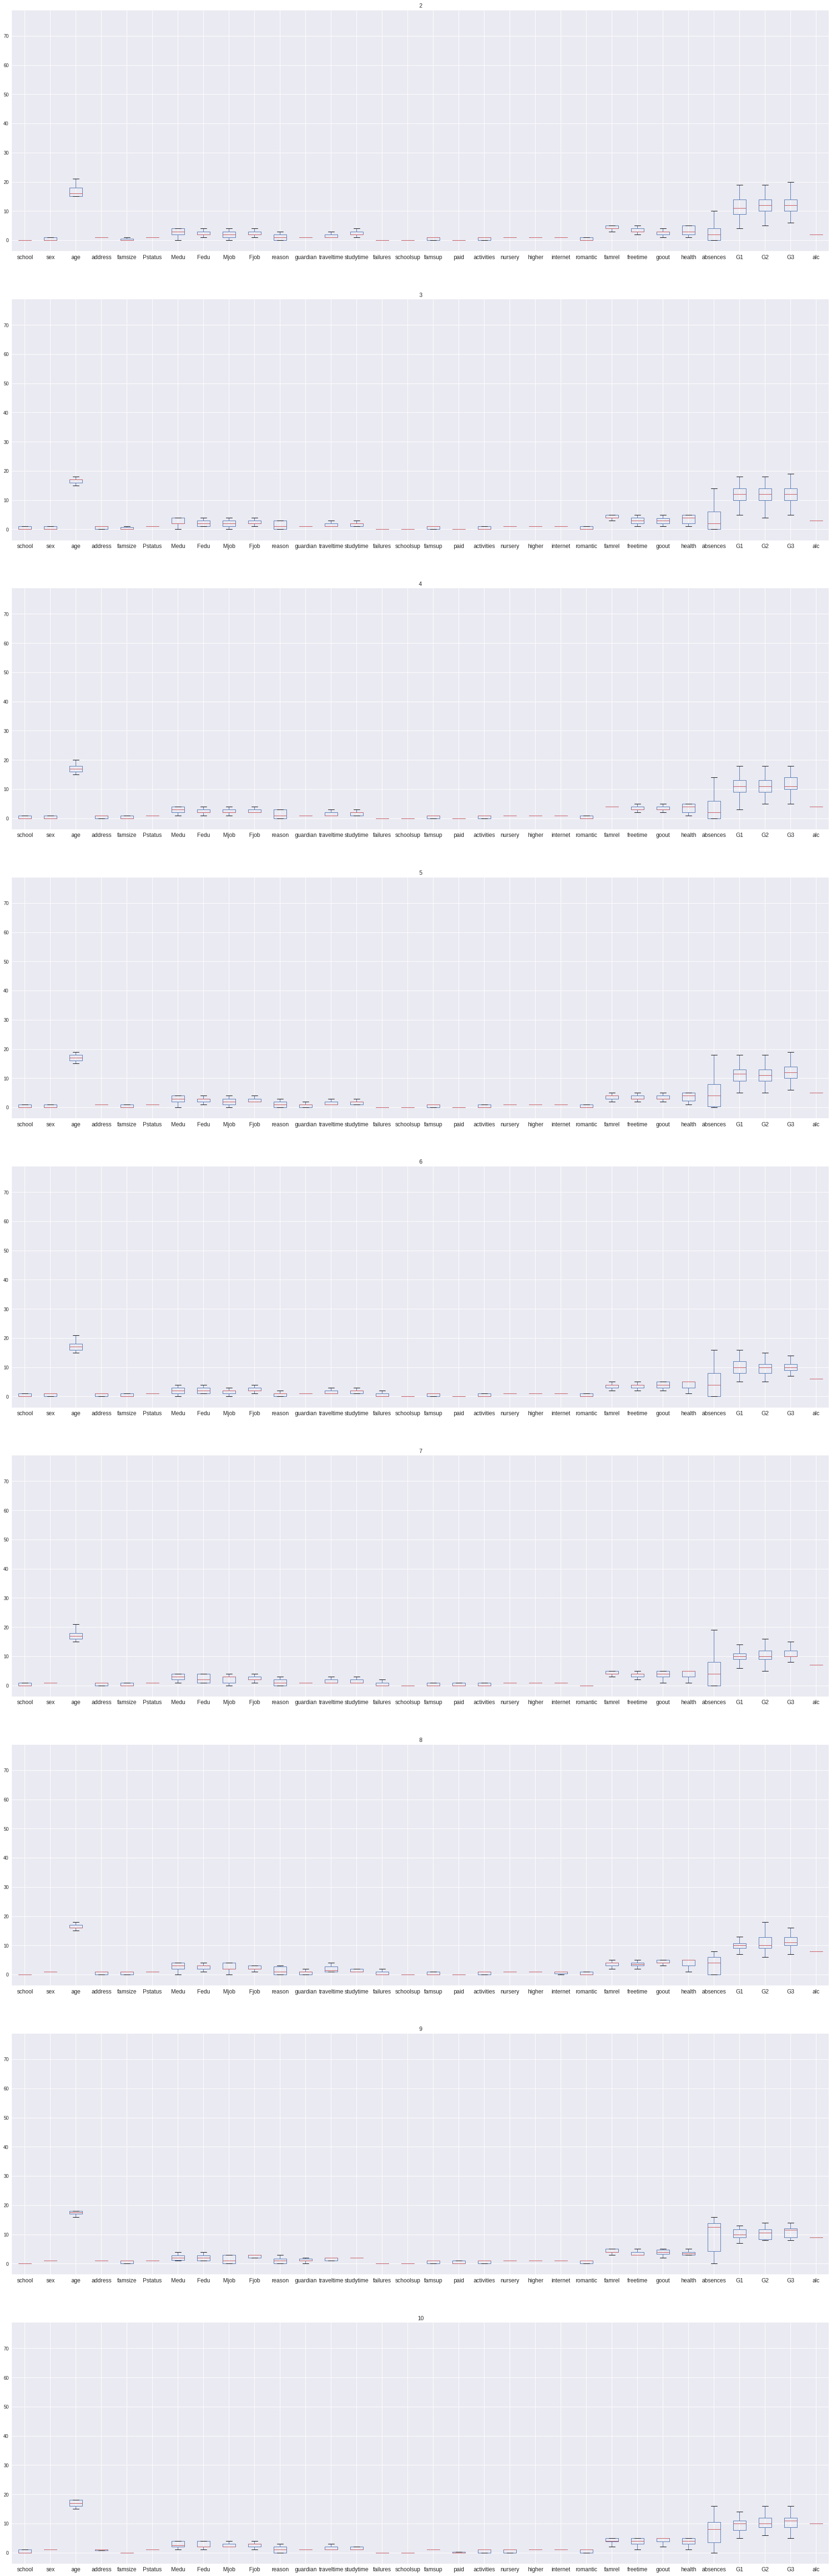

In [59]:
students.groupby('alc').boxplot(figsize = (30,100),layout = (9,1))

Анализируя графики (в частности, parallel_coordinates) можно увидеть, что наибольший разброс в потреблении алкоголя наблюдается по признаку school absences, т.е. количеству пропусков занятий в школе. Далее в порядке убывания значимости следует такие призаки, как: оценки, работа и образование родитилей, время пути до школы, причина выбора школы и т.д. Таким образом, мы можем выделить группы: 1) прогульщиков и постоянно посещяющих занятия учеников 2) живущих вблизи или вдали от школы 3) преуспевающих в учебе и нет. Используя данную информацию, мы можем построить более точную предиктивную модель, ограничивая набор признаков наиболее значимыми.